In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

## Baseline

In [2]:
train = pd.read_csv('./data/train/train.csv')

In [3]:
train.tail()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0
52559,1094,23,30,0,0,2.1,67.70,-4,0.0


In [4]:
submission = pd.read_csv('./data/sample_submission.csv')

In [5]:
submission.tail()

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7775,80.csv_Day8_23h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def cal_ghi(df):
    df['GHI']=0
    for i in range(len(df)):
        hour = df.loc[i,'Hour']
        if 8 <= hour <= 16:
            degree = (hour-7) * np.pi/18
            GHI = df.loc[i,'DNI'] + df.loc[i,'DHI']*(np.cos(90-degree))  # DHI +DNI*cos(Θ)
            if GHI<0:
                GHI=0
            df.loc[i,'GHI']=GHI

In [7]:
# data를 넣어주면 
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')   # 뒤에서 48개의 값을 지우고 가장 마지막 값으로 채운다
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill') # 뒤에서 96개의 값을 지우고 가장 마지막 값으로 채운다
        temp = temp.dropna()  # 결측치 제거
        
        return temp.iloc[:-96] # 아 이건 예측값이 0이 되버리니까 제거해버리는구나 ㅇㅋㅇㅋ

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]


df_train = preprocess_data(train)
df_train.iloc[:48]

,Hour,TARGET,DHI,DNI,WS,RH,T,Target1,Target2
0,0,0.000000,0,0,1.5,69.08,-12,0.000000,0.000000
1,0,0.000000,0,0,1.5,69.06,-12,0.000000,0.000000
2,1,0.000000,0,0,1.6,71.78,-12,0.000000,0.000000
3,1,0.000000,0,0,1.6,71.75,-12,0.000000,0.000000
4,2,0.000000,0,0,1.6,75.20,-12,0.000000,0.000000
5,2,0.000000,0,0,1.5,69.29,-11,0.000000,0.000000
6,3,0.000000,0,0,1.5,72.56,-11,0.000000,0.000000
7,3,0.000000,0,0,1.4,72.55,-11,0.000000,0.000000
8,4,0.000000,0,0,1.3,74.62,-11,0.000000,0.000000
9,4,0.000000,0,0,1.3,74.61,-11,0.000000,0.000000


In [8]:
train.iloc[48:96]

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
48,1,0,0,0,0,1.6,90.66,-10,0.000000
49,1,0,30,0,0,1.6,90.68,-10,0.000000
50,1,1,0,0,0,1.6,88.11,-11,0.000000
51,1,1,30,0,0,1.6,88.11,-11,0.000000
52,1,2,0,0,0,1.6,90.85,-11,0.000000
53,1,2,30,0,0,1.6,90.84,-11,0.000000
54,1,3,0,0,0,1.7,93.78,-12,0.000000
55,1,3,30,0,0,1.7,93.77,-12,0.000000
56,1,4,0,0,0,1.7,90.46,-12,0.000000
57,1,4,30,0,0,1.6,90.46,-12,0.000000


In [9]:
train.iloc[48+48:96+48]

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
96,2,0,0,0,0,2.2,73.80,-8,0.000000
97,2,0,30,0,0,2.1,68.20,-8,0.000000
98,2,1,0,0,0,2.1,69.06,-8,0.000000
99,2,1,30,0,0,2.1,69.04,-8,0.000000
100,2,2,0,0,0,2.2,69.38,-8,0.000000
101,2,2,30,0,0,2.2,69.36,-7,0.000000
102,2,3,0,0,0,2.2,70.03,-7,0.000000
103,2,3,30,0,0,2.2,70.02,-7,0.000000
104,2,4,0,0,0,2.3,72.18,-7,0.000000
105,2,4,30,0,0,2.4,66.78,-7,0.000000


In [10]:
df_train.tail()

,Hour,TARGET,DHI,DNI,WS,RH,T,Target1,Target2
52459,21,0.0,0,0,3.5,55.97,-1,0.0,0.0
52460,22,0.0,0,0,3.9,54.23,-2,0.0,0.0
52461,22,0.0,0,0,4.1,54.21,-2,0.0,0.0
52462,23,0.0,0,0,4.3,56.46,-2,0.0,0.0
52463,23,0.0,0,0,4.1,56.44,-2,0.0,0.0


In [11]:
cal_ghi(df_train)

In [12]:
df_train = df_train[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T','GHI','Target1','Target2']]

In [13]:
df_test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 7)

In [14]:
df_train.head()

,Hour,TARGET,DHI,DNI,WS,RH,T,GHI,Target1,Target2
0,0,0.0,0,0,1.5,69.08,-12,0.0,0.0,0.0
1,0,0.0,0,0,1.5,69.06,-12,0.0,0.0,0.0
2,1,0.0,0,0,1.6,71.78,-12,0.0,0.0,0.0
3,1,0.0,0,0,1.6,71.75,-12,0.0,0.0,0.0
4,2,0.0,0,0,1.6,75.20,-12,0.0,0.0,0.0


In [15]:
X_test.head()

,Hour,TARGET,DHI,DNI,WS,RH,T
288,0,0.0,0,0,0.8,80.92,-2.8
289,0,0.0,0,0,0.9,81.53,-2.9
290,1,0.0,0,0,1.0,79.91,-3.0
291,1,0.0,0,0,0.9,79.91,-3.0
292,2,0.0,0,0,0.9,77.20,-3.0


In [16]:
X_test['GHI']=0
for i in range(len(X_test)):
    hour = X_test.iloc[i,0] #hour
    if 8 <= hour <= 16:
        degree = (hour-7) * np.pi/18
        GHI = X_test.iloc[i,3] + X_test.iloc[i,2]*(np.cos(90-degree))  # DHI +DNI*cos(Θ)
        if GHI<0:
            GHI=0
        X_test.iloc[i,7]=GHI
X_test = X_test[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T','GHI']]

In [17]:
X_test.head(48)

,Hour,TARGET,DHI,DNI,WS,RH,T,GHI
288,0,0.000000,0,0,0.8,80.92,-2.8,0.000000
289,0,0.000000,0,0,0.9,81.53,-2.9,0.000000
290,1,0.000000,0,0,1.0,79.91,-3.0,0.000000
291,1,0.000000,0,0,0.9,79.91,-3.0,0.000000
292,2,0.000000,0,0,0.9,77.20,-3.0,0.000000
293,2,0.000000,0,0,1.1,78.36,-3.2,0.000000
294,3,0.000000,0,0,1.2,76.78,-3.4,0.000000
295,3,0.000000,0,0,1.8,77.93,-3.6,0.000000
296,4,0.000000,0,0,2.4,76.89,-3.8,0.000000
297,4,0.000000,0,0,2.9,78.64,-4.1,0.000000


In [18]:
df_train.head()

,Hour,TARGET,DHI,DNI,WS,RH,T,GHI,Target1,Target2
0,0,0.0,0,0,1.5,69.08,-12,0.0,0.0,0.0
1,0,0.0,0,0,1.5,69.06,-12,0.0,0.0,0.0
2,1,0.0,0,0,1.6,71.78,-12,0.0,0.0,0.0
3,1,0.0,0,0,1.6,71.75,-12,0.0,0.0,0.0
4,2,0.0,0,0,1.6,75.20,-12,0.0,0.0,0.0


In [19]:
df_train.iloc[-48:]

,Hour,TARGET,DHI,DNI,WS,RH,T,GHI,Target1,Target2
52416,0,0.000000,0,0,3.4,50.47,-1,0.000000,0.000000,0.000000
52417,0,0.000000,0,0,3.4,50.45,0,0.000000,0.000000,0.000000
52418,1,0.000000,0,0,3.5,50.30,0,0.000000,0.000000,0.000000
52419,1,0.000000,0,0,3.5,50.30,0,0.000000,0.000000,0.000000
52420,2,0.000000,0,0,3.5,51.14,0,0.000000,0.000000,0.000000
52421,2,0.000000,0,0,3.5,51.12,0,0.000000,0.000000,0.000000
52422,3,0.000000,0,0,3.6,52.09,0,0.000000,0.000000,0.000000
52423,3,0.000000,0,0,3.7,48.39,0,0.000000,0.000000,0.000000
52424,4,0.000000,0,0,3.8,49.00,0,0.000000,0.000000,0.000000
52425,4,0.000000,0,0,3.9,49.00,0,0.000000,0.000000,0.000000


In [20]:
df_train = df_train.drop(['DHI','DNI'],axis=1)
X_test = X_test.drop(['DHI','DNI'],axis=1)

In [21]:
X_test

,Hour,TARGET,WS,RH,T,GHI
288,0,0.0,0.8,80.92,-2.8,0.0
289,0,0.0,0.9,81.53,-2.9,0.0
290,1,0.0,1.0,79.91,-3.0,0.0
291,1,0.0,0.9,79.91,-3.0,0.0
292,2,0.0,0.9,77.20,-3.0,0.0
...,...,...,...,...,...,...
331,21,0.0,0.8,63.35,13.7,0.0
332,22,0.0,0.7,64.82,13.1,0.0
333,22,0.0,0.7,66.10,12.8,0.0
334,23,0.0,0.6,67.64,12.4,0.0


In [22]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

In [23]:
X_train_1.tail(48)

,Hour,TARGET,WS,RH,T,GHI
19129,12,38.761729,5.2,50.43,-6,371.158627
16321,0,0.000000,2.8,38.33,0,0.000000
24999,19,0.000000,1.2,63.65,16,0.000000
15246,15,27.024624,1.2,33.28,12,898.117346
3219,1,0.000000,2.9,76.65,-2,0.000000
49811,17,0.000000,4.1,53.08,8,0.000000
797,14,24.868868,3.9,39.74,3,419.337948
33523,9,35.381039,2.8,33.03,-1,932.235670
31921,0,0.000000,3.2,44.01,11,0.000000
42968,4,0.000000,1.4,62.31,9,0.000000


In [24]:
X_train_1.head()

,Hour,TARGET,WS,RH,T,GHI
32908,14,1.783051,2.3,63.64,3,13.049805
10140,6,12.103848,1.8,66.74,19,0.000000
32182,11,56.300682,2.2,39.56,13,946.818237
20953,12,65.401188,1.5,23.71,15,648.015752
36079,15,19.614206,0.5,46.63,0,592.182538


In [25]:
X_test.head()

,Hour,TARGET,WS,RH,T,GHI
288,0,0.0,0.8,80.92,-2.8,0.0
289,0,0.0,0.9,81.53,-2.9,0.0
290,1,0.0,1.0,79.91,-3.0,0.0
291,1,0.0,0.9,79.91,-3.0,0.0
292,2,0.0,0.9,77.20,-3.0,0.0


In [26]:
X_test.head()

,Hour,TARGET,WS,RH,T,GHI
288,0,0.0,0.8,80.92,-2.8,0.0
289,0,0.0,0.9,81.53,-2.9,0.0
290,1,0.0,1.0,79.91,-3.0,0.0
291,1,0.0,0.9,79.91,-3.0,0.0
292,2,0.0,0.9,77.20,-3.0,0.0


In [27]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [28]:
from lightgbm import LGBMRegressor

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [29]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

In [30]:
# Target1
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.37378
Early stopping, best iteration is:
[360]	valid_0's quantile: 1.37267
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.19116
[1000]	valid_0's quantile: 2.18345
[1500]	valid_0's quantile: 2.18324
Early stopping, best iteration is:
[1694]	valid_0's quantile: 2.18175
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.59667
[1000]	valid_0's quantile: 2.58475
[1500]	valid_0's quantile: 2.57744
Early stopping, best iteration is:
[1312]	valid_0's quantile: 2.57676


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [34]:
X_train_1

,Hour,TARGET,WS,RH,T,GHI
32908,14,1.783051,2.3,63.64,3,13.049805
10140,6,12.103848,1.8,66.74,19,0.000000
32182,11,56.300682,2.2,39.56,13,946.818237
20953,12,65.401188,1.5,23.71,15,648.015752
36079,15,19.614206,0.5,46.63,0,592.182538
...,...,...,...,...,...,...
45891,1,0.000000,1.8,84.63,13,0.000000
52416,0,0.000000,3.4,50.47,-1,0.000000
42613,18,9.664419,1.5,66.59,18,0.000000
43567,15,65.014422,3.1,12.49,31,910.759860


In [40]:
dir(models_1[1])

['_Booster',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_base_doc',
 '_best_iteration',
 '_best_score',
 '_class_map',
 '_class_weight',
 '_classes',
 '_estimator_type',
 '_evals_result',
 '_fobj',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_n_classes',
 '_n_features',
 '_n_features_in',
 '_objective',
 '_other_params',
 'alpha',
 'bagging_fraction',
 'best_iteration_',
 'best_score_',
 'booster_',
 'boosting_type',
 'class_weight',
 'colsample_bytree',
 'evals_result_',
 'feature_importances_',
 'feature_name_',
 'fit',
 'get_params',
 'importance_type',
 'learning_rate',
 'max_depth',
 'min_child_samples',
 'min_child_

In [48]:
lst = []
models_1[0].feature_importances_.tolist()

[895, 2112, 2262, 2089, 1972, 1470]

In [51]:
lst = []
for i in range(len(models_1)):    
    lst.append(models_1[i].feature_importances_.tolist())

In [61]:
imp = pd.DataFrame(lst,columns=models_1[1].feature_name_)
imp

,Hour,TARGET,WS,RH,T,GHI
0,895,2112,2262,2089,1972,1470
1,4225,9488,10921,11983,9498,4705
2,3216,7799,7823,8911,7329,4282
3,12707,34415,33784,36274,28905,15585
4,7902,20975,19502,21164,17091,10716
5,10050,29028,26158,28066,22974,15754
6,14438,40532,36008,37682,30423,22267
7,13160,35615,25798,32664,26288,21035
8,5414,13801,8708,10334,8940,10793


In [63]:
imp.sum(axis=0)

Hour       72007
TARGET    193765
WS        170964
RH        189167
T         153420
GHI       106607
dtype: int64

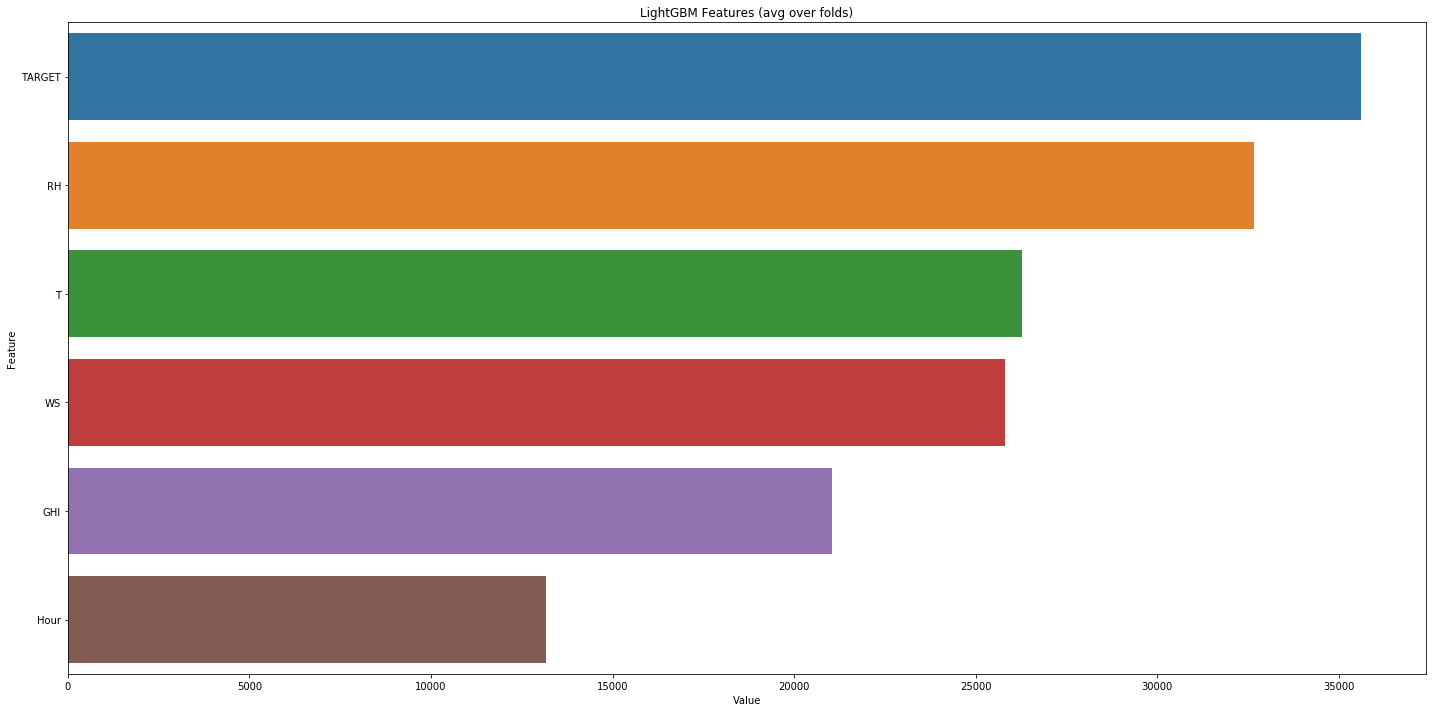

<Figure size 432x288 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(models_1[0].feature_importances_,X_train_1.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [31]:
# Target2
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.39245
Early stopping, best iteration is:
[687]	valid_0's quantile: 1.39026
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.2289
[1000]	valid_0's quantile: 2.21866
[1500]	valid_0's quantile: 2.20776
[2000]	valid_0's quantile: 2.2067
[2500]	valid_0's quantile: 2.20378
[3000]	valid_0's quantile: 2.20297
Early stopping, best iteration is:
[3050]	valid_0's quantile: 2.20256
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.63225
[1000]	valid_0's quantile: 2.6227
[15

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [32]:
results_1.sort_index().iloc[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [33]:
results_2.sort_index()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
print(results_1.shape, results_2.shape)

(3888, 9) (3888, 9)


In [51]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [53]:
submission.iloc[48:96]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
48,0.csv_Day8_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
49,0.csv_Day8_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50,0.csv_Day8_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
51,0.csv_Day8_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
52,0.csv_Day8_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
53,0.csv_Day8_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
54,0.csv_Day8_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
55,0.csv_Day8_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
56,0.csv_Day8_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57,0.csv_Day8_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [54]:
submission.to_csv('./data/+GHI-DNI,DHI.csv', index=False)